## Autoencoder

In [1]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

Load CIFAR10 data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
50000 train samples
10000 test samples


## Implement and train an autoencoder (max. 512 represantations, reconstruction error <= 0.002)

In [3]:
x_train.shape[1:]

(32, 32, 3)

In [4]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

lecun = tf.keras.initializers.LecunNormal()

encoder = Sequential([
    Conv2D(16, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu", input_shape = x_train.shape[1:]),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    MaxPooling2D(pool_size=2),
])

decoder = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides = 2, padding="same", kernel_initializer="lecun_normal", activation="selu", input_shape=[4, 4, 64]),
    Conv2DTranspose(16, kernel_size=3, strides = 2, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    Conv2DTranspose(3, kernel_size=3, strides = 2, padding="same", activation="sigmoid"),
    Reshape(x_train.shape[1:])
   ])

autoencoder = Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer = Adam())
history = autoencoder.fit(x_train, x_train, epochs=50, validation_split = 0.1)

Epoch 1/50
1407/1407 [==============================] - 9s 5ms/step - loss: 0.0111 - val_loss: 0.0075
Epoch 2/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 3/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 4/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 5/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 6/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 7/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 8/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.004

## Visualise original and reconstructed images of the test set

313/313 [==============================] - 1s 3ms/step - loss: 0.0041


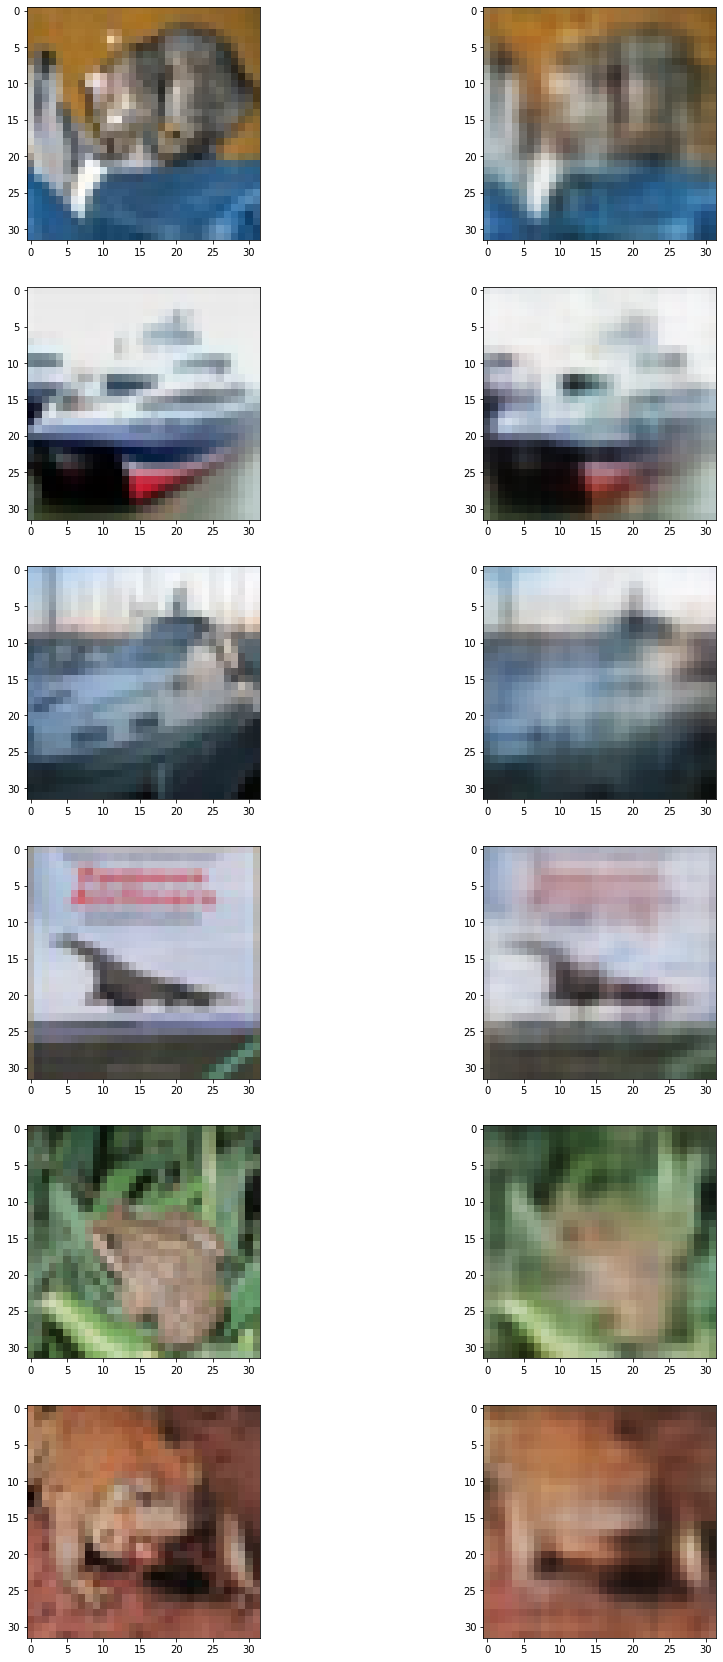

In [5]:
autoencoder.evaluate(x_test, x_test)

predictions = autoencoder.predict(x_test)
n_examples = 6
fig, axes = plt.subplots(nrows=n_examples,ncols=2, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(predictions[i])
plt.show()

## Calculate the number of trainable parameters of your autoencoder :
(kernel_size * kernel_size * filtersInLastLayer + 1) * filtersInCurrentLayer , where +1 means bias term

**encoder** :

1.   CONV3-16: (3 x 3 x 3 + 1) x 16 = 448 params
2.   POOL2 : 0 params
3.   CONV3-32: (3 x 3 x 16 + 1) x 32 = 4640 params
4.   POOL2: 0 params
5.   CONV3-64: (3 x 3 x 32 + 1) x 64 = 18496 params
6.   POOL2: 0 params 

**decoder** :

1.   CONV3-32: (3 x 3 x 64 + 1) x 32 = 18464 params
2.   POOL2 : 0 params
3.   CONV3-16: (3 x 3 x 32 + 1) x 16 = 4624 params
4.   POOL2: 0 params
5.   CONV3-3: (3 x 3 x 16 + 1) x 3 = 435 params
6.   POOL2: 0 params 

Overall trainable params: 47,107 

### Model's summary yields the same result.


In [6]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 4, 4, 64)          23584     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         23523     
Total params: 47,107
Trainable params: 47,107
Non-trainable params: 0
_________________________________________________________________


## Encode the data set

In [7]:
codings = encoder.predict(x_train)

In [8]:
codings_test = encoder.predict(x_test)

In [9]:
codings.shape, codings_test.shape

((50000, 4, 4, 64), (10000, 4, 4, 64))

## Implement and train a classifier on the encoded data.

In [10]:
# splitting encoded train data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(codings, y_train, test_size=0.98, random_state=42)

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1000, 4, 4, 64), (49000, 4, 4, 64), (1000, 10), (49000, 10))

In [12]:
model = Sequential([
    Conv2D(filters = 8, kernel_size = 3, strides=1, activation="relu", padding="same", 
                           input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides = 2),
    Conv2D(16, 3, strides = 1, activation="relu", padding="same"),
    MaxPooling2D(pool_size = 2, strides = 2),
    Flatten(),
    Dense(10, activation="softmax")
])

model.compile(optimizer = Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 8)           4616      
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 8)           32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 16)          1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [13]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
50/50 [==============================] - 1s 7ms/step - loss: 2.4121 - accuracy: 0.0962 - val_loss: 2.2830 - val_accuracy: 0.1100
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 2.1750 - accuracy: 0.2237 - val_loss: 2.2017 - val_accuracy: 0.1900
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 2.0461 - accuracy: 0.3000 - val_loss: 2.0490 - val_accuracy: 0.2300
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 1.8912 - accuracy: 0.3300 - val_loss: 1.9832 - val_accuracy: 0.2650
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 1.7739 - accuracy: 0.3913 - val_loss: 1.9690 - val_accuracy: 0.2750
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 1.6594 - accuracy: 0.4350 - val_loss: 1.8741 - val_accuracy: 0.3100
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 1.5607 - accuracy: 0.4512 - val_loss: 1.8383 - val_accuracy: 0.3650
Epoch 8/30
50/50 [==

In [17]:
# Option 2 of the model

model2 = Sequential([
    Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=X_train.shape[1:]),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model2.compile(optimizer = Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

model2.summary()

history = model2.fit(X_train, Y_train, epochs=30, batch_size=16, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

## Add noise to the images and use the autoencoder as a denoiser to predict the original images from the noisy images (sigma = 0.06, reconstruction error <= 0.0025)

In [25]:
mean = 0.0  
std = 0.06  

x_train_noised = x_train + np.random.normal(mean, std, x_train.shape)
x_test_noised = x_test + np.random.normal(mean, std, x_test.shape)

In [27]:
x_train_noised.shape, x_test_noised.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [26]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

encoder2 = Sequential([
    Conv2D(16, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu", input_shape = x_train_noised.shape[1:]),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    MaxPooling2D(pool_size=2),
])

decoder2 = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides = 2, padding="same", kernel_initializer="lecun_normal", activation="selu", input_shape=[4, 4, 64]),
    Conv2DTranspose(16, kernel_size=3, strides = 2, padding="same", kernel_initializer="lecun_normal", activation="selu"),
    Conv2DTranspose(3, kernel_size=3, strides = 2, padding="same", activation="sigmoid"),
    Reshape(x_train.shape[1:])
   ])

autoencoder2 = Sequential([encoder2, decoder2])

autoencoder2.compile(loss="mse", optimizer = Adam())
history2 = autoencoder2.fit(x_train_noised, x_train, epochs=50, validation_split = 0.1)

Epoch 1/50
1407/1407 [==============================] - 8s 5ms/step - loss: 0.0112 - val_loss: 0.0077
Epoch 2/50
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 3/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 4/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 5/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 6/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/50
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 8/50
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.005

Visualise the noise-less images, the noisy images and the reconstructed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


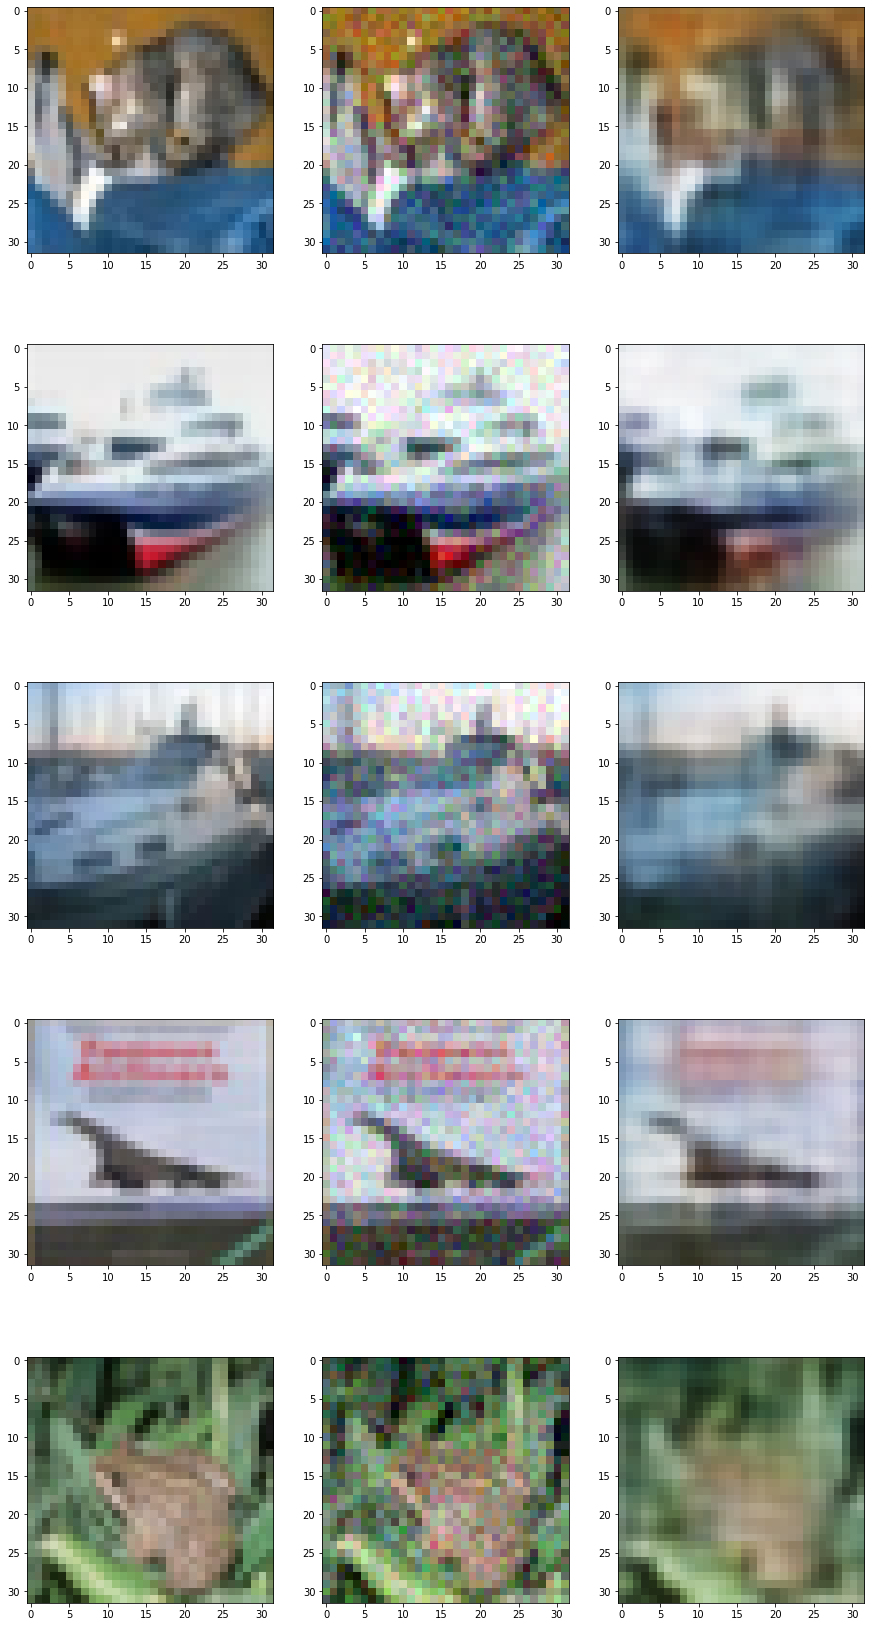

In [28]:
denoised_predictions = autoencoder2.predict(x_test_noised)

n_examples = 5
fig, axes = plt.subplots(nrows=n_examples,ncols=3, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(x_test_noised[i])
    axes[i][2].imshow(denoised_predictions[i])
plt.show()